### Before we begin...
* If you have git working, and want to update the course materials directly from GitHub:
    * Navigate to the SSI2018 directory on your drive
    * Once inside the SSI2018 directory, type `git pull` (ideally you should use `git fetch`, but...)
    * Note: you may receive a warning about merge conflicts. In this case, you have several options:
        * If you **don't** want to keep any edits you've made, you can:
            * Follow the instructions [here](https://stackoverflow.com/a/8888015/2445984) (recommended)
            * `git stash` and then repeat the pull (kind of a hack)
        * If you **do** want to keep your edits, you can:
            * `git clone` the SSI2018 repo (see last class slides) to a different location
            * Resolve the merge conflict manually (which we won't cover in class)

# Overview of Day 2
* Motivation
* A working dataset
* Importing data
* Pandas data structures
* Preprocessing data
* Working with text*

# Motivation
* Data preparation is the un-sexy part of data science
* But in many ways, the most important part
* Choice of statistical estimator sometimes makes no practical difference
    * "More data beats better algorithms" ([Domingos, 2012](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.715.3497&rep=rep1&type=pdf))
* Small differences in preprocessing choices can ramify quickly
    * E.g., variable smoothing or transformation, outlier removal, etc.

# Dataset
* The City of Austin has an [Open Data Portal](https://data.austintexas.gov/) containing many interesting datasets
* We'll use [outcome data](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238) from the Austin Animal Center
* 65,605 outcomes between October 2013, and May 2018
* Variables include the type, age, sex, breed, name, and color of the animal, plus the outcome

### Some questions we can ask
* What do people in Austin name their cats and dogs?
* What are the most common dog and cat breeds processed at the animal center?
* Do outcomes differ (e.g., euthanasia vs. adoption) for different breeds?
    * Are purebred dogs more likely to be adopted than mixes?
* Does animal size (e.g., big vs. small dogs) have any impact on outcomes?
* How well can we predict the likely outcome given everything we know about an animal?
* Do outcomes vary over time--e.g., by day of week, season, year, etc.?

## Import all the things

It's conventional when writing Python code to list all of the imports at the top of the file. That way you can quickly see exactly what modules and functions are being used, and it's easier to manage dependencies. In the following code cell, we'll import everything we're going to use in this notebook. Don't worry if you don't recognize some of the imported modules; we'll discuss most of them as we go.

In [3]:
# We'll consolidate all our imports at the top today
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

# You may need to install the packages below. You can
# probably just uncomment the next line and re-run the cell
# !conda install beautifulsoup4 requests seaborn -y
from bs4 import BeautifulSoup
import requests
import seaborn as sns

# Disable annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Importing data
* Before we do anything else, we need to get our data into a usable form
* Most commonly, data will come from a flat file
* But sometimes we need to retrieve data from other sources
* We'll do both

### Reading in data with the standard library
There are many ways to read in data into Python. Let's start by using the standard library--though this is just a learning exercise; in practice you would almost never have a good reason to do it this way.

In [8]:
# Use os.path.join to ensure that the right separator is used
filename = os.path.join('..', 'data', 'Austin_Animal_Center_Outcomes.csv') 

data = []  # Initialize an empty list to store the data

# Loop over rows in the file. readlines() returns a list of
# lines, so we can directly iterate it to get each line.
for line in open(filename).readlines():
    # Strip beginning or trailing whitespace from each line
    line = line.strip()
    # Split the comma-separated values into a list
    line = line.split(',')

    # Append the row to the dataset
    data.append(line)

print("Found {} rows.".format(len(data)))

Found 82720 rows.


In [6]:
# Print the 1000th row to see what it looks like
data[1000]

['A755451',
 '',
 '08/07/2017 05:51:00 PM',
 '08/07/2017 05:51:00 PM',
 '05/16/2017',
 'Adoption',
 '',
 'Cat',
 'Spayed Female',
 '2 months',
 'Domestic Shorthair Mix',
 'Blue/White']

The problem with approaches like the one above is that the data lack a tabular format, making it very hard to operate over rows or columns. We're much better off using the _pandas_ package to hold our data in a pandas DataFrame (DF)--a data structure that wraps around numpy arrays and is expressly designed to support a range of powerful operations over data. Reading a dataset into a pandas DF is very easy with the workhorse [read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) or [read_table()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) methods. These methods take a large number of optional arguments that make it easy to read in almost any kind of orderly data represented in a text file.

#### Reading data, the pandas way

In [10]:
# Pandas can read data from either a local file or a remote URL.
# We'll default to reading directly from GitHub, but if you have
# the Animal Center data available locally, comment out the next
# line and uncomment the following one for faster loading.
filename = "https://raw.githubusercontent.com/tyarkoni/SSI2018/master/data/Austin_Animal_Center_Outcomes.csv"
# filename = "../data/Austin_Animal_Center_Outcomes.csv"

# The workhorse data-reading method in pandas.
# It accepts a LOT of optional arguments. You can see them
# by executing ?pd.read_csv to bring up the documentation.
data = pd.read_csv(filename)

In [13]:
# calling head() on a DataFrame shows the first N rows.
# Let's take a look and see what our data look like...
data.tail(10)

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
82709,A698560,NaN,05/09/2015 12:35:00 PM,05/09/2015 12:35:00 PM,03/11/2015,Adoption,NaN,Dog,Spayed Female,1 month,Labrador Retriever/Boxer,Tricolor
82710,A701865,NaN,05/05/2015 03:33:00 PM,05/05/2015 03:33:00 PM,04/30/2015,Euthanasia,Underage,Other,Unknown,5 days,Opossum,Gray
82711,A701383,NaN,04/28/2015 04:45:00 PM,04/28/2015 04:45:00 PM,04/21/2015,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Black/White
82712,A699175,Mojo,04/30/2015 04:41:00 PM,04/30/2015 04:41:00 PM,03/23/2011,Euthanasia,Aggressive,Dog,Neutered Male,4 years,Boerboel Mix,Tan/White
82713,A700847,NaN,04/25/2015 04:29:00 PM,04/25/2015 04:29:00 PM,07/20/2014,Transfer,Partner,Dog,Intact Female,9 months,German Shepherd Mix,Brown/Black
82714,A701871,NaN,05/09/2015 06:54:00 PM,05/09/2015 06:54:00 PM,05/05/2014,Adoption,NaN,Bird,Intact Male,1 year,Chicken,Yellow/White
82715,A700829,Rocky,04/29/2015 04:53:00 PM,04/29/2015 04:53:00 PM,04/16/2009,Return to Owner,NaN,Dog,Neutered Male,6 years,Shih Tzu/Miniature Schnauzer,Black/Gray
82716,A702051,NaN,05/08/2015 02:32:00 PM,05/08/2015 02:32:00 PM,05/08/2012,Return to Owner,NaN,Dog,Spayed Female,3 years,Chihuahua Shorthair Mix,Brown
82717,A700956,Mars,04/28/2015 04:45:00 PM,04/28/2015 04:45:00 PM,04/21/2014,Adoption,NaN,Dog,Neutered Male,1 year,Miniature Poodle/Australian Cattle Dog,Blue Tick/Black
82718,A694429,Lilly,04/27/2015 07:20:00 PM,04/27/2015 07:20:00 PM,12/28/2012,Adoption,NaN,Dog,Spayed Female,2 years,Pit Bull Mix,Black/White


## Other formats
Pandas has built-in support for [reading from or to other common formats/sources](http://pandas.pydata.org/pandas-docs/stable/io.html):
* Generic delimited text -- `read_csv()` or `read_table()`
* Excel -- `read_excel()`
* JSON -- `read_json()`
* SQL -- `read_sql()`
* Stata -- `read_stata()`
* SAS (XPORT or SAS7BDAT) -- `read_sas()`
* etc...

## Scraping data
* What if we want to add some data to our dataset?
* It would be nice if we had height and weight estimates for dog breeds
    * Are there different outcomes for bigger vs. smaller dogs?
* We track down a website that has some [breed information](https://www.wisdompanel.com/explore-breed/breeds-detected/)
* Now we need to "scrape" that data and get it into Python/pandas

In [ ]:
# To make our requests realistic, we'll pretend we're using Chrome on a Mac.
# Without this, many websites will reject our request.
headers = { 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2227.1 Safari/537.36'}

# The page listing all the breeds available from Wisdom Panel
url = "https://www.wisdompanel.com/explore-breed/breeds-detected/"

# Get the HTML contents of the page
html = requests.get(url).text

# Create a BeautifulSoup document
soup = BeautifulSoup(html, 'html.parser')

# Extract links to all breeds with BeautifulSoup
breed_links = soup.select('div.breeds-accordion-inn a')

breed_links = ["http://www.wisdompanel.com" + a['href'] for a in breed_links]
print("Retrieving data for {} breeds.".format(len(breed_links)))

breed_data = []

# Note: I've deliberately limited the scraping to the first 3 breeds.
# You can run this to see how it works, but there's no point in having
# everyone scrape all 200+ dog breeds, since I've made the scraped data
# available in the GitHub repo, and we'll use that below.
for breed in breed_links[:3]:

    try:
        breed_html = requests.get(breed, headers=headers).text

        # Use regular expressions to extract name, height, and weight. It would probably be
        # easier to use BeautifulSoup for this, but we want to illustrate the use of regexes.
        
        # Breed name shows up prominently at the top
        name = re.search('content="(.*?)\s\|\sWisdom Panel"', breed_html, re.DOTALL).group(1)

        # For height and weight, first get the enclosing div with BeautifulSoup
        breed_soup = BeautifulSoup(breed_html, 'html.parser')
        trait_divs = breed_soup.select('div.appearance-row')

        # We have multiple traits, so let's store them in a dictionary
        traits = {}
        
        # Now loop over each detected trait and parse into key-value pairs
        # using regular expressions
        for div in trait_divs:
            div_text = div.text.strip()
            pattern = '(.*?):\s+(\d+)[\s-]+(\d+)'
            matches = re.search(pattern, div_text, re.DOTALL)
            # There are three matched groups. We can assign them
            # to three variables in parallel in Python.
            trait_name, min_val, max_val = matches.groups()
            # Store each trait in our traits dict
            traits[trait_name] = [min_val, max_val]
            
        print("Data extracted for breed '{}':".format(name), traits)
        
        # Consolidate all of the extracted values in a single row.
        # We'll only keep the weight range for pets, not for show dogs.
        breed_row = [name] + traits['Height'] + traits['Weight (pet)']
#         print("Retrieved breed data: ", breed_row)
        breed_data.append(breed_row)
        
    # Some breed pages have formatting errors, so we'll just skip them
    except Exception as e:
        print("An unspecified error occurred while retrieving data for a breed.")
        pass

# Put the data in a pandas DataFrame
col_names = ['breed_name', 'min_height', 'max_height', 'min_weight', 'max_weight']
breed_data = pd.DataFrame(breed_data, columns=col_names)

# Create output directory if it doesn't exist
output_dir = os.path.join('..', 'data')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the breed data locally for re-use
output_file = os.path.join(output_dir, 'breed_data.csv')
breed_data.to_csv(output_file, index=False, encoding='utf8'),
print("Successfully saved breed data to {}.".format(output_file))


#### The scraped breed data

We'll come back later to the breed data we just scraped and saved. But for now, let's see what it looks like.

In [15]:
# We'll use the already-scraped data in the repository,
# to prevent hammering Wisdom Panel's server.
breed_data = pd.read_csv('https://raw.githubusercontent.com/tyarkoni/SSI2018/master/data/breed_data.csv')

breed_data

,breed_name,min_height,max_height,min_weight,max_weight
0,Affenpinscher,9,11,5,14
1,Afghan Hound,25,29,40,77
2,Airedale Terrier,22,24,36,67
3,Akita,24,28,60,121
4,Alaskan Klee Kai,13,17,12,24
5,Alaskan Malamute,23,28,61,105
6,Bulldog (American),20,28,62,118
7,American English Coonhound,23,26,40,65
8,American Eskimo Dog,9,19,16,30
9,American Foxhound,21,25,42,67


## Regular expressions
* The heavy lifting in the previous scraping code is done with regular expressions
* A powerful system for detecting and capturing patterns in text
* One of the most underutilized features of programming languages
    * Not just in Python! R, SAS, Stata, and most other language support regex
* A short regular expression can replace dozens of lines of string-processing code
* Lots of good tutorials ([1](https://developers.google.com/edu/python/regular-expressions), [2](http://regexone.com/references/python), [3](http://www.learnpython.org/en/Regular_Expressions))

In [16]:
# A snippet of HTML from the Alaskan Malamute's breed
# website on wisdompanel.com. We want to extract just the
# height information.
text = '''
<div class="appearance-row">
    <span class="label">Height:</span>
    <span class="value">23 - 28 in</span>
</div>
'''

# Extract with regular expressions. In this case,
# We're looking to capture two groups of numbers,
# corresponding to the minimum and maximum height.
# We can use the "value" class name as a useful
# marker to indicate where to start scanning for
# matches. 
pattern = 'value"\>(\d+)[\s-]+(\d+)'

# Search for pattern within text.
# The re.DOTALL flag indicates that we want to match
# across multiple lines of text, including newlines.
matches = re.search(pattern, text, re.DOTALL)

# We should have two matching groups, so we can
# assign them to two variables in parallel.
min_height, max_height = matches.groups()

print(min_height, max_height)

23 28


### Some simple regex examples

In [19]:
# Let's define a string we'll apply regexes to
text = "A few additional examples (maybe 4 or 5) illustrating the power of regular expressions!!"

In [20]:
# Extract all text beginning with 'add' and ending in 'power'.

# The period ('.') matches any character; the asterisk indicates
# the pattern should be matched as many times as possible.
re.search('(add.*power)',  text).group(1)

'additional examples (maybe 4 or 5) illustrating the power'

In [21]:
 # All numbers in the text. Note the use of findall()
# instead of search() or match().
re.findall('(\d+)', text)

['4', '5']

In [24]:
# All words between 5 and 8 characters in length
re.findall(r'\b([a-zA-Z]{5,8})\b', text)

['examples', 'maybe', 'power', 'regular']

# Pandas data structures
* pandas provides functionality similar to data frames in R
* Two main data structures: Series and DataFrames
    * DataFrames: 2-dimensional numpy array with labeled rows and columns
    * Series: 1-dimensional numpy array with labeled values

In [29]:
# Initialize a Series from a numpy array and index labels
a = np.arange(3, 8)
labels = ['apple', 'banana', 'orange', 'pear', 'grapes']
fruits = pd.Series(a, index=labels)

# Let's take a look...
fruits

apple     3
banana    4
orange    5
pear      6
grapes    7
dtype: int64

In [31]:
# Unlike numpy arrays, we can now refer to elements by label.
# The syntax is similar to dictionary indexing. You can also
# treat labels like attributes (e.g., b.pear), but this runs
# the risk of collisions and should be avoided.
fruits['pear']

6

In [140]:
# We can always retrieve the underlying numpy array with .values
fruits.values

array([3, 4, 5, 6, 7])

In [33]:
# Many numpy operations work as expected, including slicing
fruits[2:4]

orange    5
pear      6
dtype: int64

### The pandas DataFrame
* The workhorse of data analysis in pandas
* A container of multiple aligned Series
* Heterogeneous: a DF's Series can have different dtypes

#### Indexing pandas DataFrames
* pandas DFs support [flexible indexing](http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing) by labels and/or indices
    * A common gotcha: R-style indexing won't work
    * Be explicit about whether you're using integer or label indexing

In [34]:
# Let's remind ourselves what the data look like
data.head(5)

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A741715,*Pebbles,01/11/2017 06:17:00 PM,01/11/2017 06:17:00 PM,03/07/2016,Adoption,NaN,Cat,Spayed Female,10 months,Domestic Shorthair Mix,Calico
1,A658751,Benji,11/13/2016 01:38:00 PM,11/13/2016 01:38:00 PM,07/14/2011,Return to Owner,NaN,Dog,Neutered Male,5 years,Border Terrier Mix,Tan
2,A721285,NaN,02/24/2016 02:42:00 PM,02/24/2016 02:42:00 PM,02/24/2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon Mix,Black/Gray
3,A697000,Boone,02/16/2015 01:24:00 PM,02/16/2015 01:24:00 PM,02/16/2009,Return to Owner,NaN,Dog,Neutered Male,6 years,English Springer Spaniel Mix,Liver/White
4,A697055,Megatron,02/17/2015 03:06:00 PM,02/17/2015 03:06:00 PM,02/17/2012,Adoption,NaN,Dog,Spayed Female,3 years,Dachshund/Chihuahua Shorthair,Red


In [35]:
# This won't work!
data[0, 'Animal Type']

KeyError: (0, 'Animal Type')

In [36]:
# .ix supports mixed positional and label-based access.
# But note that this  is deprecated! Can anyone guess
# why this type of indexing could cause trouble?
data.ix[0, 'Animal Type']

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


'Cat'

In [41]:
# Returns the entire column
data['Animal Type']

0          Cat
1          Dog
2        Other
3          Dog
4          Dog
5          Dog
6          Cat
7          Dog
8          Dog
9          Dog
10       Other
11         Dog
12         Dog
13         Cat
14         Cat
15       Other
16         Dog
17         Dog
18         Dog
19         Cat
20         Dog
21         Dog
22         Cat
23         Dog
24         Dog
25         Dog
26         Dog
27         Cat
28         Cat
29         Cat
         ...  
82689      Dog
82690      Cat
82691      Cat
82692      Dog
82693      Dog
82694      Dog
82695      Cat
82696      Dog
82697      Cat
82698      Dog
82699      Cat
82700      Cat
82701      Dog
82702      Cat
82703      Cat
82704      Dog
82705      Dog
82706      Cat
82707      Dog
82708      Dog
82709      Dog
82710    Other
82711      Cat
82712      Dog
82713      Dog
82714     Bird
82715      Dog
82716      Dog
82717      Dog
82718      Dog
Name: Animal Type, Length: 82719, dtype: object

In [48]:
# Position-based selection; returns all of rows 2 - 5
data.iloc[2:5, :]

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
2,A721285,NaN,02/24/2016 02:42:00 PM,02/24/2016 02:42:00 PM,02/24/2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon Mix,Black/Gray
3,A697000,Boone,02/16/2015 01:24:00 PM,02/16/2015 01:24:00 PM,02/16/2009,Return to Owner,NaN,Dog,Neutered Male,6 years,English Springer Spaniel Mix,Liver/White
4,A697055,Megatron,02/17/2015 03:06:00 PM,02/17/2015 03:06:00 PM,02/17/2012,Adoption,NaN,Dog,Spayed Female,3 years,Dachshund/Chihuahua Shorthair,Red


In [50]:
# Returns rows 2 - 5, columns 2 and 7
data.iloc[2:5, [2, 7]] 

,DateTime,Animal Type
2,02/24/2016 02:42:00 PM,Other
3,02/16/2015 01:24:00 PM,Dog
4,02/17/2015 03:06:00 PM,Dog


In [52]:
# Label-based indexing; equivalent to data['Animal Type']
# in this case
data.loc[:, 'Animal Type']

0          Cat
1          Dog
2        Other
3          Dog
4          Dog
5          Dog
6          Cat
7          Dog
8          Dog
9          Dog
10       Other
11         Dog
12         Dog
13         Cat
14         Cat
15       Other
16         Dog
17         Dog
18         Dog
19         Cat
20         Dog
21         Dog
22         Cat
23         Dog
24         Dog
25         Dog
26         Dog
27         Cat
28         Cat
29         Cat
         ...  
82689      Dog
82690      Cat
82691      Cat
82692      Dog
82693      Dog
82694      Dog
82695      Cat
82696      Dog
82697      Cat
82698      Dog
82699      Cat
82700      Cat
82701      Dog
82702      Cat
82703      Cat
82704      Dog
82705      Dog
82706      Cat
82707      Dog
82708      Dog
82709      Dog
82710    Other
82711      Cat
82712      Dog
82713      Dog
82714     Bird
82715      Dog
82716      Dog
82717      Dog
82718      Dog
Name: Animal Type, Length: 82719, dtype: object

### A quick summary of the data
We'll cover descriptive analyses in more detail tomorrow, but for now, a basic summary:

In [53]:
data.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,82719,57400,82719,82719,82719,82708,37832,82719,82716,82715,82719,82719
unique,74637,15016,68135,68135,6046,9,19,5,5,46,2201,536
top,A721033,Bella,04/18/2016 12:00:00 AM,04/18/2016 12:00:00 AM,09/01/2015,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,16,371,39,39,115,35006,20650,47107,29358,15338,24319,8630


# Preprocessing our data
Much of what data scientists do involves cleaning and preprocessing data:
* Handling missing or invalid values
* Extracting usable information from messy strings
* Transforming/normalizing variables and variable names
* Filtering redundant or bad data
* Merging with other datasets
* Etc...

## Some examples
* There's far too much to cover in 2 hours, so we'll cherry-pick useful examples
* There are many excellent tutorials and guides (e.g., [1](http://www.gregreda.com/2013/10/26/intro-to-pandas-data-structures/), [2](http://synesthesiam.com/posts/an-introduction-to-pandas.html), [3](https://github.com/fonnesbeck/statistical-analysis-python-tutorial))

## Renaming/replacing
The column names in our dataset are kind of clunky. Let's make it a bit easier to work with the dataset by standardizing and shortening them.

In [54]:
# This is no good
data.columns

Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed', 'Color'],
      dtype='object')

In [57]:
# Dictionary of old names --> new names.
# Notice that we don't need to provide replacements
# for _all_ the columns,  just the ones we want to
# replace. An alternative approach would be to
# directly set data.columns to a list of the
# desired new column names.
replacements = {
    'Animal ID': 'id',
    'DateTime': 'datetime',
    'Outcome Type': 'outcome',
    'Outcome Subtype': 'outcome_subtype',
    'Animal Type': 'animal',
    # We append these with '_string' because we're going
    # to use the names 'sex' and 'age' later for
    # extracted variables, so this avoids confusion.
    'Sex upon Outcome': 'sex_string',
    'Age upon Outcome': 'age_string',
}

# We can apply the rename function to either row names
# or column names. Here we're doing columns.
data = data.rename(columns=replacements)

# Let's also make sure all column names are in lowercase.
# We're using a Python idiom called a "list comprehension",
# which is basically a more compact way to write a for-loop.
data.columns = [c.lower() for c in data.columns]

# # # The above list comprehension is functionally equivalent
# # # to the following for-loop:
# columns = []
# for col in data.columns:
#     lower_col = col.lower()
#     columns.append(lower_col)
# data.columns = columns

## Working with time series data
* The datetime column in our dataset is currently represented as a string
* We want to treat it as a datetime, so we can easily extract information
* Let's convert its time to datetime and pull out some useful columns

In [61]:
# These are actually strings/objects, not datetimes!
print(data['datetime'][:3])

0    01/11/2017 06:17:00 PM
1    11/13/2016 01:38:00 PM
2    02/24/2016 02:42:00 PM
Name: datetime, dtype: object


In [62]:
# Convert the datetime column to actual datetimes.
# Note that this operation can take a bit of time when
# working with large datasets, because pandas has to
# inspect each individual string and try to make sense
# of it. There are other faster ways to go about this,
# but they would require us to explicitly specify the
# format the datetimes are in, which is a hassle, and
# might run into problems if there are multiple formats.
data['datetime'] = pd.to_datetime(data['datetime'])
 
# Now we're working with datetimes
print(data['datetime'][:3])

0   2017-01-11 18:17:00
1   2016-11-13 13:38:00
2   2016-02-24 14:42:00
Name: datetime, dtype: datetime64[ns]


Now we can easily extract some useful time-related variables for later use (e.g., year, day of week, etc.).

In [63]:
# Datetime-related functions are accessed through the .dt attribute
data['year'] = data['datetime'].dt.year
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.weekday

data.head(3)

,id,name,datetime,monthyear,date of birth,outcome,outcome_subtype,animal,sex_string,age_string,breed,color,year,hour,day
0,A741715,*Pebbles,2017-01-11 18:17:00,01/11/2017 06:17:00 PM,03/07/2016,Adoption,NaN,Cat,Spayed Female,10 months,Domestic Shorthair Mix,Calico,2017,18,2
1,A658751,Benji,2016-11-13 13:38:00,11/13/2016 01:38:00 PM,07/14/2011,Return to Owner,NaN,Dog,Neutered Male,5 years,Border Terrier Mix,Tan,2016,13,6
2,A721285,NaN,2016-02-24 14:42:00,02/24/2016 02:42:00 PM,02/24/2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon Mix,Black/Gray,2016,14,2


## Parsing text data
* Many datasets contain nominal/categorical variables that need to be recoded as numeric variables
* Three common strategies:
    * Transform a nominal variable into a continuous one
    * Break down a compound nominal label into constituent numeric variables
    * "Dummy-code" a nominal variable as a set of binary variables

### Representing animal age with numeric values
The age column in our DF has nasty values like "3 years" and "7 months"

In [69]:
data['age_string'].unique()

array(['10 months', '5 years', '2 years', '6 years', '3 years', '1 year',
       '2 weeks', '9 years', '5 months', '1 month', '4 months', '3 weeks',
       '4 years', '11 years', '2 months', '3 months', '10 years',
       '8 years', '13 years', '6 months', '1 week', '8 months',
       '9 months', '4 weeks', '12 years', '7 years', '1 weeks', '5 days',
       '3 days', '11 months', '7 months', '14 years', '2 days', '5 weeks',
       '15 years', '16 years', '6 days', '4 days', '17 years', '0 years',
       '18 years', '1 day', '20 years', '19 years', '22 years',
       '25 years', nan], dtype=object)

#### Converting descriptive age strings to months of age
* How do we convert these strings to numeric values we can operate on?
* We can take advantage of pandas' apply() functionality, which applies arbitrary methods to each value in a Series (or each column or row in a DataFrame).

In [77]:
def extract_months(value):
    ''' Extract and return age in months from string values 
    "3 years" or "7 months".
    
    Note: this code won't work as written, because some of
    the values passed in are invalid.
    
    In-class exercise: we modify the code to return the
    special value np.nan (numpy's representation of not-a-number)
    whenever an invalid value is encountered.
    '''
    if pd.isnull(value):
        return np.nan

    number, unit = value.split(' ')
    number = int(number)
    unit = unit.lower()

    if unit.startswith('year'):
        number = number * 12
    
    elif unit.startswith('week'):
        number /= 4.0
        
    elif unit.startswith('day'):
        number /= 30.0

    return number

data['age'] = data['age_string'].apply(extract_months)

In [78]:
# Notice any problems in the output? (Hint: week)
# As an exercise, you can fix this by tweaking the
# extract_months() method we wrote above and rerunning
# the previous code block. 
data[['age_string', 'age']][:10]

,age_string,age
0,10 months,10.0
1,5 years,60.0
2,2 years,24.0
3,6 years,72.0
4,3 years,36.0
5,1 year,12.0
6,2 weeks,0.5
7,1 year,12.0
8,1 year,12.0
9,9 years,108.0


### Just for kicks...
We're not ready to cover plotting just yet, but since we now have our first continuous variable, let's reward ourselves by plotting something nice to look at...

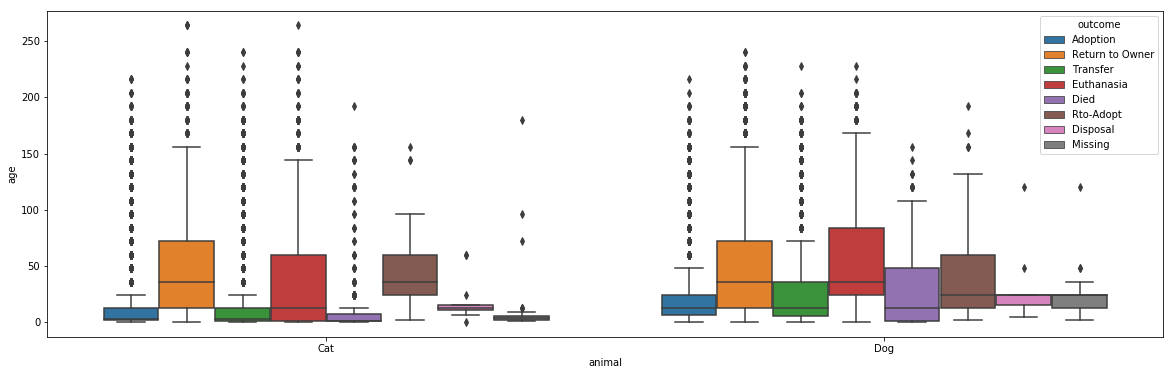

In [87]:
tmp_data = data.query('animal in ["Dog", "Cat"]')
sns.boxplot(x='animal', y='age', data=tmp_data, hue='outcome')
plt.gcf().set_size_inches((20, 6))

### Extracting data from the sex column
* The original column combines sex and sterilization status into one column

In [89]:
data['sex_string'].value_counts()

Neutered Male    29358
Spayed Female    26560
Intact Male      10069
Intact Female     9647
Unknown           7082
Name: sex_string, dtype: int64

Let's recode this as two binary variables: sex (male/female) and sterilized (True/False)

In [94]:
# NOTE: The code below will fail the first time you run it. Why?
# Because there's a single NaN value that messes up the indexing.
# These kinds of errors are pervasive in real-world datasets.
# We need to recode the NaN--which we can do by setting it to
# 'Unknown', just like the other 3,625 Unknown values. To do
# that, uncomment the next line and re-run.

data['sex_string'] = data['sex_string'].fillna('Unknown')

# Initialize a new column with NaN as the default value (for unknown sex)
data['sex'] = np.nan

# Update the column with values for M (0) and F (1)
is_male = data['sex_string'].str.contains('Male')
data['sex'][is_male] = 0
data['sex'][data['sex_string'].str.contains('Female')] = 1

# Now do the same kind of thing for sterilization
data['sterilized'] = 1
data['sterilized'][data['sex_string'].str.contains('Intact')] = 0
data['sterilized'][data['sex_string'].str.contains('Unknown')] = np.nan

In [95]:
data[['sex_string', 'sex', 'sterilized']][:10]

,sex_string,sex,sterilized
0,Spayed Female,1.0,1.0
1,Neutered Male,0.0,1.0
2,Unknown,NaN,NaN
3,Neutered Male,0.0,1.0
4,Spayed Female,1.0,1.0
5,Intact Female,1.0,0.0
6,Intact Male,0.0,0.0
7,Spayed Female,1.0,1.0
8,Neutered Male,0.0,1.0
9,Neutered Male,0.0,1.0


Note: an alternative (and simpler) way to do the above would have been to use pandas' .replace() method. As an exercise, rewrite the code above to achieve the same goal using .replace(). (Hint: create a dictionary of values to find and replace.)

### Dummy-coded variables
* Categorical variables with N levels often need to be modeled as N binary indicators
* E.g., day-of-week is coded 0 through 6, but should be modeled as 6 or 7 contrasts
* pandas makes this easy with get_dummies()

In [103]:
# We can also specify drop_first=True (on pandas >= 0.18) in order to
# use N - 1 columns instead of N (e.g., to reduce collinearity).
# It's also often useful to pass a prefix argument, which is prepended
# to all the level names.
pd.get_dummies(data['outcome'])[:5]

,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0


## Filtering data
* It's very common to want to filter out certain rows/columns

### Dropping uncommon outcomes
* Let's take a look at all of the different outcomes...

In [105]:
# Show the frequencies of all of the different  outcomes
data['outcome'].value_counts()

Adoption           35006
Transfer           24705
Return to Owner    15265
Euthanasia          6430
Died                 722
Disposal             312
Rto-Adopt            202
Missing               49
Relocate              17
Name: outcome, dtype: int64

* Some outcomes in the dataset are too rare to merit analyzing
    * We already saw how extra levels clutter up our plots and understanding
* Let's impose a minimum cut-off of 1000 occurrences for outcomes to be kept

#### A naive approach
How would we solve this problem in pure Python, without pandas?

In [106]:
# Approach 1: the most naive approach, without
# taking advantage of anything pandas has to offer.
# This is slower and involves much more code than
# the pandas-based solutions, but it works just fine.
# To illustrate the logic behind what we're doing,
# we use only native Python here, and no fancy idioms.
# The other approaches do similar things under the
# hood, but take advantage of many optimizations and
# functions written in C to greatly speed things up.

# Get the raw outcome values as a list
values = data['outcome'].tolist()

# Initialize a dictionary to store running counts of
# all the outcomes.
counts = {}

# Loop over values and increment the appropriate
# outcome's counter.
for v in values:
    if v not in counts:
        counts[v] = 0
    counts[v] += 1

# Select the outcomes we want to keep--only those
# above 1000 occurrences.
min_count = 1000

# Initialize a list to store only the valid outcomes
valid_outcomes = []

# Loop over the outcome-count pairs in the dictionary
# and keep only those above the threshold.
for outcome, count in counts.items():
    if count >= min_count:
        valid_outcomes.append(outcome)

# Identify the valid rows in the pandas DataFrame
rows_to_keep = []
for i, row in data.iterrows():
    if row['outcome'] in valid_outcomes:
        rows_to_keep.append(row)

# Turn this list of Series back into a DataFrame
filtered_data = pd.DataFrame(rows_to_keep)

# Count the number of rows we have left and print them out
n_rows = filtered_data.shape[0]
print("After filtering, we have {} rows in the dataset.".format(n_rows))

After filtering, we have 81406 rows in the dataset.


#### A better way
* The pure Python approach works, but it's slow and very verbose
* We can do much better with pandas

In [107]:
# Approach 2: We do essentially the same thing, but now we
# take advantage of various built-in pandas methods.
# Notice how much shorter--and faster!--the solution is.

# Count the number of occurrences of each outcome
counts = data['outcome'].value_counts()

# # Keep only those above a threshold--say 1000
valid_inds = counts >= 1000
valid_outcomes = counts[valid_inds].index

# Now select only dataset rows with those outcomes
valid_rows = data['outcome'].isin(valid_outcomes)
filtered_data = data[valid_rows]

print("After filtering, we have {} rows in the dataset.".format(filtered_data.shape[0]))

After filtering, we have 81406 rows in the dataset.


#### An even better way
* That was much better. But we can do this even _more_ efficiently...
* We'll use the split-apply-combine pattern

#### The [split-apply-combine](https://www.jstatsoft.org/article/view/v040i01/v40i01.pdf) pattern
* A very common data processing strategy
    * Split the dataset into groups
    * Apply some operation(s) to each group
    * (Optionally) combine back into one dataset
* pandas provides powerful and fast tools for this

#### Calculate the mean age of each animal species

In [114]:
# A simple example: calculate the mean age of each animal species

# Split the dataset on animal. This creates a pandas GroupBy object.
groups = data.groupby('animal')

# pandas provides many built-in operations on groups--e.g., mean, count, etc.
# see http://pandas.pydata.org/pandas-docs/stable/groupby.html#groupby-object-attributes
# groups['age'].mean()

# The above line can also be more explicitly written as:
# groups['age'].aggregate('mean')

#### Count the number of animals of each species that are older than 12 months

In [118]:
# We can apply arbitrary methods to each group.
# Here we use a small "lambda function" (comparable to
# an anonymous function in JavaScript, R, or Matlab)
# to count the number of animals of each species
# that are older than 12 months.
groups = data.groupby(['animal'])
groups['age'].apply(lambda x: (x > 12).sum())

# A functionally equivalent, but more explicit way of
# doing the above would be:

# def count_animals_older_than_12_months(x):
#     return (x > 12).sum()

# groups['age'].apply(count_animals_older_than_12_months)

animal
Bird            75
Cat           7220
Dog          24466
Livestock        3
Other         1235
Name: age, dtype: int64

#### Filtering uncommon outcomes: the one-line solution
With the above pattern in mind, we can now turn back to our outcome-filtering problem and solve it in one line.

In [119]:
# Approach 3: Use groupby() and a short lambda function.

filtered_data = data.groupby('outcome').filter(lambda x: x.shape[0] >= 1000)

print("After filtering, we have {} rows in the dataset.".format(filtered_data.shape[0]))

After filtering, we have 81406 rows in the dataset.


### Filtering animals for only the last outcome
* Some animals have multiple outcomes in the dataset
* Why might this be?

In [125]:
# Count number of outcomes per animal
outcome_counts = data.groupby('id')['outcome'].count()

# How many animals with more than one outcome?
outcome_counts[outcome_counts > 1].count()

6361

* We probably want to analyze only the _last_ outcome for each animal
* This also becomes easy with the groupby strategy

In [126]:
# Recall that we have a datetime column we can sort on,
# to put all outcomes in chronological order.
data = data.sort_values('datetime')

# Group on animal and then use the built-in last() function
filtered_data = data.groupby('id').last()

# Note the handy comma injection the Python format method provides
print("Before filtering: {:,} rows".format(len(data)))
print("After filtering: {:,} rows".format(len(filtered_data)))

Before filtering: 82,719 rows
After filtering: 74,637 rows


## Merging datasets
* It's very common to need to combine data from different sources
* Remember the breed data we scraped?
* Let's merge it into our main DataFrame
    * Will allow us to test whether weight or height matter
* This is a more complicated operation

### The problem
* We want to merge or 'join' our outcome data with the breed data
* The obvious column to join on here is the breed name
* But the names don't line up! Compare:

In [128]:
print(data['breed'].value_counts().index[:10])

Index(['Domestic Shorthair Mix', 'Pit Bull Mix', 'Chihuahua Shorthair Mix',
       'Labrador Retriever Mix', 'Domestic Medium Hair Mix',
       'German Shepherd Mix', 'Bat Mix', 'Domestic Longhair Mix',
       'Australian Cattle Dog Mix', 'Siamese Mix'],
      dtype='object')


In [129]:
print(breed_data['breed_name'].value_counts().index[:10])

Index(['Neapolitan Mastiff', 'Leonberger', 'Soft Coated Wheaten Terrier',
       'Schipperke', 'Field Spaniel', 'Staffordshire Bull Terrier',
       'Poodle (Miniature)', 'Australian Shepherd', 'Sloughi',
       'English Setter'],
      dtype='object')


Here's what we'll do:
* Drop terms like "mix", "shorthair" and "longhair" that don't occur in the official names
* For mixed breeds in our outcome data, we'll only use the first breed
* For the most common breeds, we'll manually recode names so that they align
* Note that all these steps are imperfect; our data will be noisy
    * When munging data, we often need to decide how good is good enough

In [133]:
# Restrict analysis only to dogs, since that's all we have breed info for.
# Notice our use of the query function, which enables us to perform SQL-like
# queries over DataFrames.
dogs = data.query('animal == "Dog"')

# Let's prepare a 'merge_key' column in our outcome data that should line up
# as well as possible with the breed_name column in the breed_data DataFrame.
# We'll start by dropping all occurrences of 'Mix', 'Shorthair', etc.
dogs['merge_key'] = dogs['breed'].replace([' Mix', ' Shorthair', ' Longhair'], '', regex=True)

# Next, we'll keep only the first breed in cases where there are multiple given.
# For example, "Beagle/Labrador Retriever" would become just "Beagle".
dogs['merge_key'] = dogs['merge_key'].str.split('/').str.get(0)

# Manually map the most common breeds that don't align. I've cheated here
# and done a bit of extra work ahead of time to figure out what these are.
replacements = {
    "Pit Bull": "American Staffordshire Terrier",
    "Staffordshire": "Staffordshire Bull Terrier",
    "German Shepherd": "German Shepherd Dog",
    "Anatol Shepherd": "Anatolian Shepherd Dog",
    "Australian Shepherd": "Australian Shepherd Dog",
    "Catahoula": "Catahoula Leopard Dog",
    "American Pit Bull Terrier": "American Staffordshire Terrier", 
    "Doberman Pinsch": "Doberman Pinscher",  
}

# Apply the replacements
dogs['merge_key'] = dogs['merge_key'].replace(replacements)

# Finally, we're in a position to merge our data.
# We have to tell pandas which columns to use in each of the two datasets.
# We can also specify how we want the join to work ('left', 'outer',
# 'inner', etc.). The default is left, meaning that the output DataFrame
# will have the same number of rows as the first input DataFrame (dogs).
dogs = dogs.merge(breed_data, left_on='merge_key', right_on='breed_name', how='left')

In [132]:
dogs.head(20)

,id,name,datetime,monthyear,date of birth,outcome,outcome_subtype,animal,sex_string,age_string,...,day,age,sex,sterilized,merge_key,breed_name,min_height,max_height,min_weight,max_weight
0,A659834,*Dudley,2013-10-01 09:31:00,10/01/2013 09:31:00 AM,07/23/2013,Adoption,Foster,Dog,Neutered Male,2 months,...,1,2.0,0.0,1.0,Labrador Retriever,Labrador Retriever,21.0,24.0,49.0,77.0
1,A664223,Moby,2013-10-01 11:03:00,10/01/2013 11:03:00 AM,09/30/2009,Return to Owner,NaN,Dog,Neutered Male,4 years,...,1,48.0,0.0,1.0,Bulldog,Bulldog,12.0,16.0,32.0,68.0
2,A663646,NaN,2013-10-01 11:12:00,10/01/2013 11:12:00 AM,09/22/2010,Transfer,Partner,Dog,Neutered Male,3 years,...,1,36.0,0.0,1.0,Toy Poodle,NaN,NaN,NaN,NaN,NaN
3,A663888,NaN,2013-10-01 11:13:00,10/01/2013 11:13:00 AM,09/25/2011,Transfer,Partner,Dog,Spayed Female,2 years,...,1,24.0,1.0,1.0,Boxer,Boxer,21.0,25.0,49.0,77.0
4,A663572,*Starla,2013-10-01 11:42:00,10/01/2013 11:42:00 AM,09/21/2010,Adoption,NaN,Dog,Spayed Female,3 years,...,1,36.0,1.0,1.0,Anatolian Shepherd Dog,Anatolian Shepherd Dog,27.0,30.0,81.0,147.0
5,A663833,Baby Girl,2013-10-01 11:50:00,10/01/2013 11:50:00 AM,09/24/2004,Return to Owner,NaN,Dog,Spayed Female,9 years,...,1,108.0,1.0,1.0,Labrador Retriever,Labrador Retriever,21.0,24.0,49.0,77.0
6,A663342,Deco,2013-10-01 12:05:00,10/01/2013 12:05:00 PM,09/17/2012,Euthanasia,Behavior,Dog,Neutered Male,1 year,...,1,12.0,0.0,1.0,Chesa Bay Retr,NaN,NaN,NaN,NaN,NaN
7,A664225,Lou,2013-10-01 12:13:00,10/01/2013 12:13:00 PM,09/30/2010,Return to Owner,NaN,Dog,Neutered Male,3 years,...,1,36.0,0.0,1.0,Shih Tzu,Shih Tzu,10.0,11.0,10.0,21.0
8,A663546,*Gage,2013-10-01 12:24:00,10/01/2013 12:24:00 PM,09/20/2011,Euthanasia,Aggressive,Dog,Neutered Male,2 years,...,1,24.0,0.0,1.0,American Bulldog,NaN,NaN,NaN,NaN,NaN
9,A664258,Sylvio,2013-10-01 12:27:00,10/01/2013 12:27:00 PM,10/01/2006,Return to Owner,NaN,Dog,Neutered Male,7 years,...,1,84.0,0.0,1.0,Weimaraner,Weimaraner,22.0,27.0,54.0,97.0


# What else?

In [134]:
# Code goes here...

# Your (optional) assignment for tomorrow
* We extracted a numeric representation of several categorical variables
    * We could extract many more
* Some more variables we'll probably look at when we turn to fitting models:
    * Animal color
    * Whether the animal is a purebreed or mix
    * Whether the outcome resulted in an animal's death (e.g., Died + Euthanasia)
* Extract anything else you think might be useful